In [740]:
# here we want to build functions to load NR waveforms from different NR codes

In [741]:
import matplotlib.pyplot as plt
plt.figure()
plt.show()
plt.close()
plt.rcParams.update({'font.size':16})

<Figure size 432x288 with 0 Axes>

In [742]:
import ffi_utils

import numpy as np
import h5py
import configparser

from scipy.interpolate import InterpolatedUnivariateSpline as IUS

import phenom

In [743]:
class NRLoader(object):
    def __init__(self, handler, nr_hdf5_filename=None, psi4_filename=None, metadata_filename=None, safety_factor=0.5, ell=None, mm=None, dt=0.1, psi4_t1=None, psi4_t2=None):
        """
        code: e.g. 'nr_hdf5', 'bam'

        nr_hdf5 kwargs
         - nr_hdf5_filename
         - ell
         - mm

        bam kwargs
         - psi4_filename
         - metadata_filename
         - safety_factor: for ffi
         - psi4_t1, psi4_t2. used to mask the psi4 data between these times
        """
        self.handler = handler
        self.nr_hdf5_filename = nr_hdf5_filename
        self.psi4_filename = psi4_filename
        self.metadata_filename = metadata_filename
        self.safety_factor = safety_factor
        self.ell = ell
        self.mm = mm
        self.dt = dt
        self.psi4_t1 = psi4_t1
        self.psi4_t2 = psi4_t2

        if self.handler == 'bam':
            assert self.psi4_filename != None, "expecting psi4_filename"
            assert self.metadata_filename != None, "expecting metadata_filename"
            self.get_bam_strain_from_psi4(self.psi4_filename, self.metadata_filename, safety_factor=self.safety_factor, dt=self.dt, psi4_t1=self.psi4_t1, psi4_t2=self.psi4_t2)
        elif self.handler == 'nr_hdf5':
            assert self.nr_hdf5_filename != None, "expecting nr_hdf5_filename"
            assert self.ell != None, "expecting ell"
            assert self.mm != None, "expecting mm"
            self.get_hdf5_strain(nr_hdf5_filename=self.nr_hdf5_filename, ell=self.ell, mm=self.mm, dt=self.dt)

    def get_bam_strain_from_psi4(self, psi4_filename, bbh_metadata_filename, safety_factor, dt, psi4_t1=None, psi4_t2=None):
        # cut off frequency for FFI
        self.f0 = ffi_utils.getCutoffFrequencyFromTwoPuncturesBBH(meta_filename=bbh_metadata_filename, safety_factor=safety_factor)

        times, re_psi4, im_psi4 = np.loadtxt(psi4_filename, unpack=True)

        if psi4_t1 == None:
            psi4_t1 = times[0]
        if psi4_t2 == None:
            psi4_t2 = times[-1]


        mask = (times >= psi4_t1) & (times <= psi4_t2)
        times = times[mask]
        re_psi4 = re_psi4[mask]
        im_psi4 = im_psi4[mask]

        psi4_3col = np.column_stack((times, re_psi4, im_psi4))

        strain = ffi_utils.psi4ToStrain(psi4_3col, self.f0)
        strain = strain[:,1].conj()
        # strain_2col = strain

        re_strain = strain.real
        im_strain = strain.imag

        i_re_strain = IUS(times, re_strain)
        i_im_strain = IUS(times, im_strain)

        times = np.arange(times[0], times[-1], dt)
        re_strain = i_re_strain(times)
        im_strain = i_im_strain(times)

        strain = re_strain - 1.j*im_strain

        self.times = times
        self.strain = strain


        config = configparser.ConfigParser(strict=False)
        config.read(bbh_metadata_filename)

        # spin1x = float(config['metadata']['initial-bh-spin1x'])
        # spin1y = float(config['metadata']['initial-bh-spin1y'])
        # spin1z = float(config['metadata']['initial-bh-spin1z'])
        # spin2x = float(config['metadata']['initial-bh-spin2x'])
        # spin2y = float(config['metadata']['initial-bh-spin2y'])
        # spin2z = float(config['metadata']['initial-bh-spin2z'])
        mass1_tmp = float(config['metadata']['mass1'])
        mass2_tmp = float(config['metadata']['mass2'])

        if mass1_tmp >= mass2_tmp:
            mass1 = mass1_tmp
            mass2 = mass2_tmp
        else:
            mass1 = mass2_tmp
            mass2 = mass1_tmp

        self.Mtotal = mass1+mass2
        self.q = mass1/mass2
        self.eta = phenom.eta_from_q(self.q)


    def get_hdf5_strain(self, nr_hdf5_filename, ell, mm, dt):
        f = h5py.File(nr_hdf5_filename, 'r')

        eta = f.attrs['eta']
        # this try/except is here because the GTech waveforms
        # use 'irreducible_mass1' instead of 'mass1'..
        try:
            q = f.attrs['mass1']/f.attrs['mass2']
            self.Mtotal = f.attrs['mass1']+f.attrs['mass2']
        except:
            q = f.attrs['irreducible_mass1']/f.attrs['irreducible_mass2']
            self.Mtotal = f.attrs['irreducible_mass1']+f.attrs['irreducible_mass2']

        self.q = q
        self.eta = eta
        
        amp_tmp = f['amp_l{0}_m{1}'.format(ell, mm)]
        amp_x = amp_tmp['X'][()]
        amp_y = amp_tmp['Y'][()]

        phase_tmp = f['phase_l{0}_m{1}'.format(ell, mm)]
        phase_x = phase_tmp['X'][()]
        phase_y = phase_tmp['Y'][()]

        f.close()

        amp_i = IUS(amp_x, amp_y)
        phase_i = IUS(phase_x, phase_y)

        t1 = max(amp_x[0], phase_x[0])
        t2 = min(amp_x[-1], phase_x[-1])
            
        # common_times = np.linspace(t1, t2, npts)
        common_times = np.arange(t1, t2, dt)

        amplist = amp_i(common_times)
        phaselist = phase_i(common_times)

        times = common_times
        amp = amplist
        phi = phaselist
        strain = amp * np.exp(-1.j * phi)

        self.times = times
        self.strain = strain


In [744]:
# nrl = NRLoader(handler='bam', nr_hdf5_filename=None, psi4_filename=None, metadata_filename=None, safety_factor=0.5, ell=None, mm=None, dt=0.1)
nrl = NRLoader(
    handler='bam',
    psi4_filename='/Users/sebastian.khan/Desktop/q18a0a0c025_144/psi3col.r9.l4.l2.m2.gz',
    metadata_filename='/Users/sebastian.khan/Desktop/q18a0a0c025_144/q18a0a0c025_144.bbh',
    dt=0.1,
    safety_factor=0.5,
    )

In [745]:
nrl.f0

0.07552855422383593

In [746]:
nrl.Mtotal

0.9999987

In [747]:
nrl.q

17.998126782264087

In [748]:
nrl.eta

0.04986613903727722

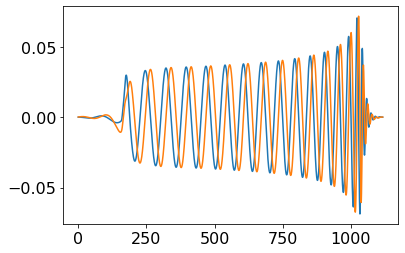

In [749]:
plt.figure()
plt.plot(nrl.times, nrl.strain.real)
plt.plot(nrl.times, nrl.strain.imag)

(900.0, 1200.0)

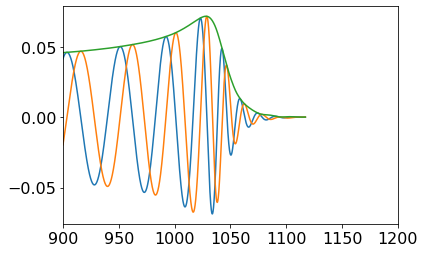

In [750]:
plt.figure()
plt.plot(nrl.times, nrl.strain.real)
plt.plot(nrl.times, nrl.strain.imag)
plt.plot(nrl.times, np.abs(nrl.strain))
plt.xlim(900, 1200)

In [751]:
nrl2 = NRLoader(handler='nr_hdf5', nr_hdf5_filename='/Users/sebastian.khan/personal/data/SXS_BBH_0180_Res4.h5', ell=2, mm=2, dt=0.1)
# 

In [752]:
nrl2.times

array([-9270.54509615, -9270.44509615, -9270.34509615, ...,
         236.15490389,   236.25490389,   236.35490389])

In [753]:
nrl2.times[1]-nrl2.times[0]

0.1000000000003638

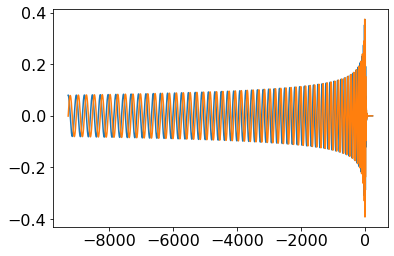

In [754]:
plt.figure()
plt.plot(nrl2.times, nrl2.strain.real)
plt.plot(nrl2.times, nrl2.strain.imag)

In [755]:
nrl2.Mtotal

0.999999970503

In [756]:
nrl2.q

1.000000000542

# try all codes

In [757]:
!ls /Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r*.l*.l2.m2*

/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r1.l6.l2.m2.gz
/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r2.l6.l2.m2.gz
/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r3.l6.l2.m2.gz
/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r4.l6.l2.m2.gz
/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r5.l6.l2.m2.gz
/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r6.l6.l2.m2.gz


In [758]:
bam_q4 = {
    'metadata':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/q4a0_T_112_448.bbh",
    'psi4':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_112_448/Psi4ModeDecomp/psi3col.r6.l6.l2.m2.gz"
}

# bam_q4 = {
#     'metadata':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_96_384/q4a0_T_96_384.bbh",
#     'psi4':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_96_384/Psi4ModeDecomp/psi3col.r6.l6.l2.m2.gz"
# }

# bam_q4 = {
#     'metadata':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_80_320/q4a0_T_80_320.bbh",
#     'psi4':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q4a0a0/q4a0_T_80_320/Psi4ModeDecomp/psi3col.r6.l6.l2.m2.gz"
# }

sxs_q4 = {
    'nrfile':'/Users/sebastian.khan/personal/data/SXS_BBH_0167_Res5.h5'
}

gt_q4 = {
    'nrfile':'/Volumes/ancient/get-nr-data/gt/gt-waveform-catalog/h5files/GT0454.h5'
}

rit_q4 = {
    'nrfile':"/Volumes/ancient/get-nr-data/rit/RIT-simulations/Data/ExtrapStrain_RIT-eBBH-1133-n100.h5"
}

In [762]:
bam_q10 = {
    'metadata':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q10S0/q10c25e_T_112_448/q10c25e_T_112_448.bbh",
    'psi4':"/Volumes/ancient/get-nr-data/bam/data/gluster/gw-data/NR_data/backup-minion-data/ReducedData/q10S0/q10c25e_T_112_448/Psi4BAMModes/psi3col_bam_r7.l4.l2.m2.gz"
}

sxs_q10 = {
    'nrfile':'/Users/sebastian.khan/personal/data/SXS_BBH_0303_Res4.h5'
}

gt_q10 = {
    'nrfile':'/Volumes/ancient/get-nr-data/gt/gt-waveform-catalog/h5files/GT0568.h5'
}

rit_q10 = {
    'nrfile':'/Volumes/ancient/get-nr-data/rit/RIT-simulations/Data/ExtrapStrain_RIT-BBH-0978-n144.h5'
}

In [763]:
nrls={}

# nrls['bam'] = NRLoader(handler='bam', psi4_filename=bam_q4['psi4'], metadata_filename=bam_q4['metadata'], dt=0.1, safety_factor=0.2)
# nrls['sxs'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=sxs_q4['nrfile'], ell=2, mm=2, dt=0.1)
# nrls['gt'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=gt_q4['nrfile'], ell=2, mm=2, dt=0.1)
# nrls['rit'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=rit_q4['nrfile'], ell=2, mm=2, dt=0.1)

nrls['bam'] = NRLoader(handler='bam', psi4_filename=bam_q10['psi4'], metadata_filename=bam_q10['metadata'], dt=0.1, safety_factor=0.3)
nrls['sxs'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=sxs_q10['nrfile'], ell=2, mm=2, dt=0.1)
nrls['gt'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=gt_q10['nrfile'], ell=2, mm=2, dt=0.1)
nrls['rit'] = NRLoader(handler='nr_hdf5', nr_hdf5_filename=rit_q10['nrfile'], ell=2, mm=2, dt=0.1)


# 

In [764]:
nrls['bam'].f0

0.04710990065164042

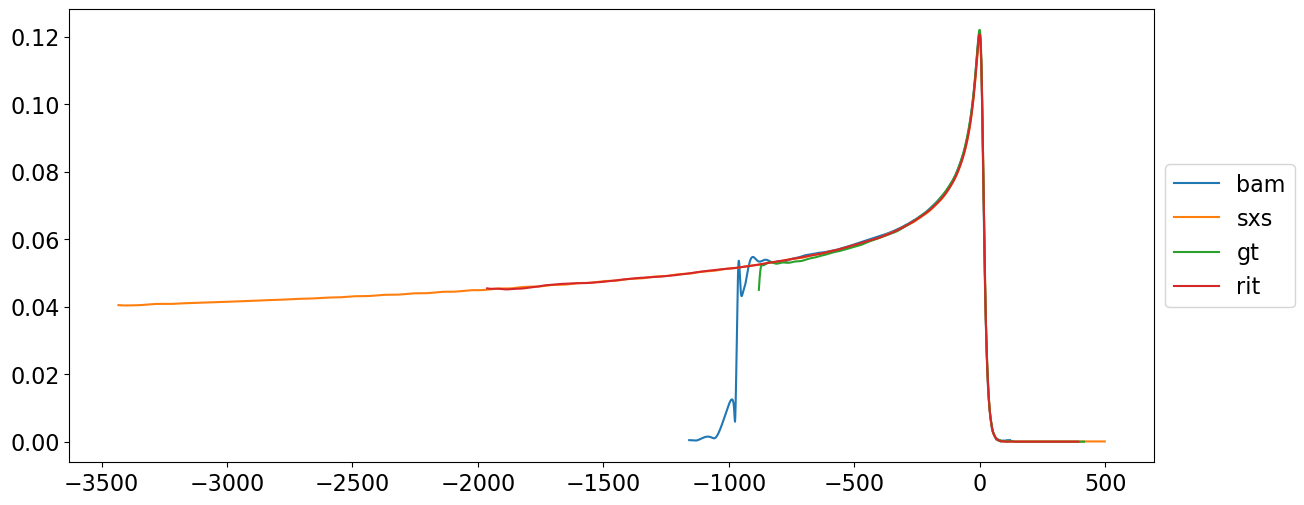

In [765]:
plt.figure(figsize=(14, 6), dpi=100)
for k in nrls.keys():
    t = nrls[k].times
    s = nrls[k].strain
    peak_idx = np.argmax(np.abs(s))
    t_max = t[peak_idx]

    # plt.plot(t-t_max, s.real, label=k)
    plt.plot(t-t_max, np.abs(s), label=k)
    # plt.plot(t, np.abs(s), label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

(-300.0, 150.0)

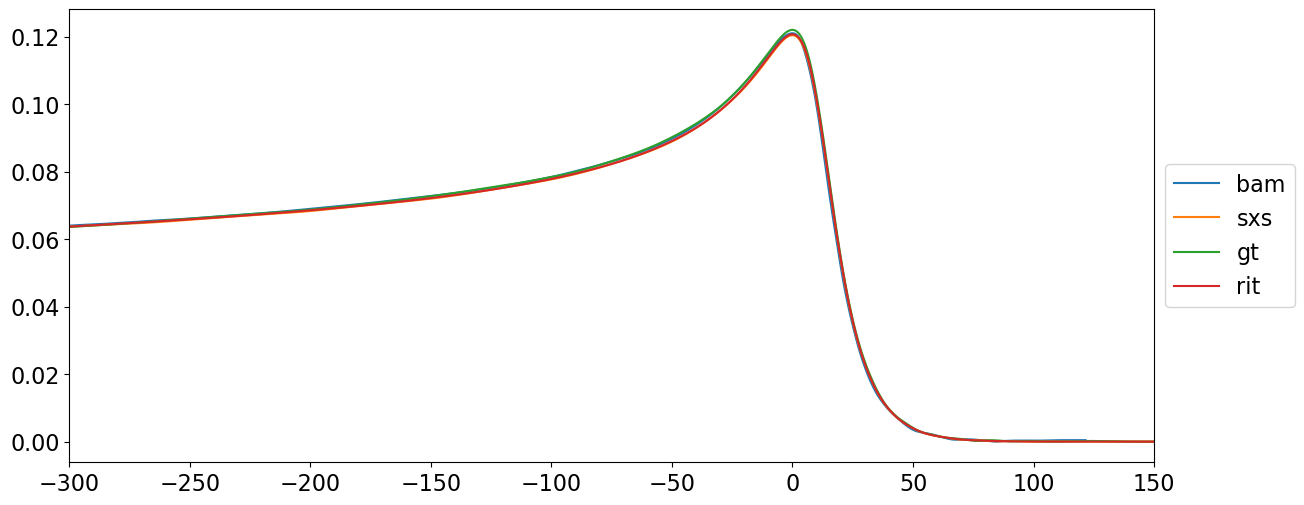

In [766]:
plt.figure(figsize=(14, 6), dpi=100)
for k in nrls.keys():
    t = nrls[k].times
    s = nrls[k].strain
    peak_idx = np.argmax(np.abs(s))
    t_max = t[peak_idx]

    # plt.plot(t-t_max, s.real, label=k)
    plt.plot(t-t_max, np.abs(s), label=k)
    # plt.plot(t, np.abs(s), label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-300, 150)
# plt.ylim(1e-4, 1)
# plt.yscale('log')
# plt.axvline(2250)

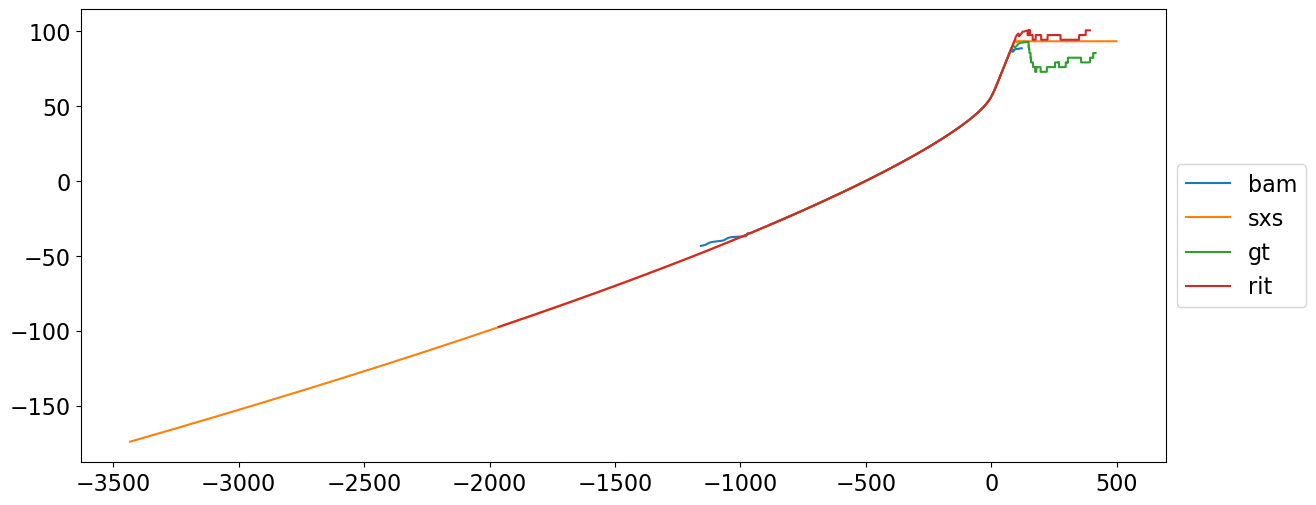

In [767]:
plt.figure(figsize=(14, 6), dpi=100)
for k in nrls.keys():
    t = nrls[k].times
    s = nrls[k].strain
    peak_idx = np.argmax(np.abs(s))
    t_max = t[peak_idx]

    amp = np.abs(s)
    phi = np.unwrap(np.angle(s))

    phi0 = IUS(t-t_max, phi)(-500)

    plt.plot(t-t_max, phi-phi0, label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# plt.xlim(-100, 250)

(0.01, 0.6)

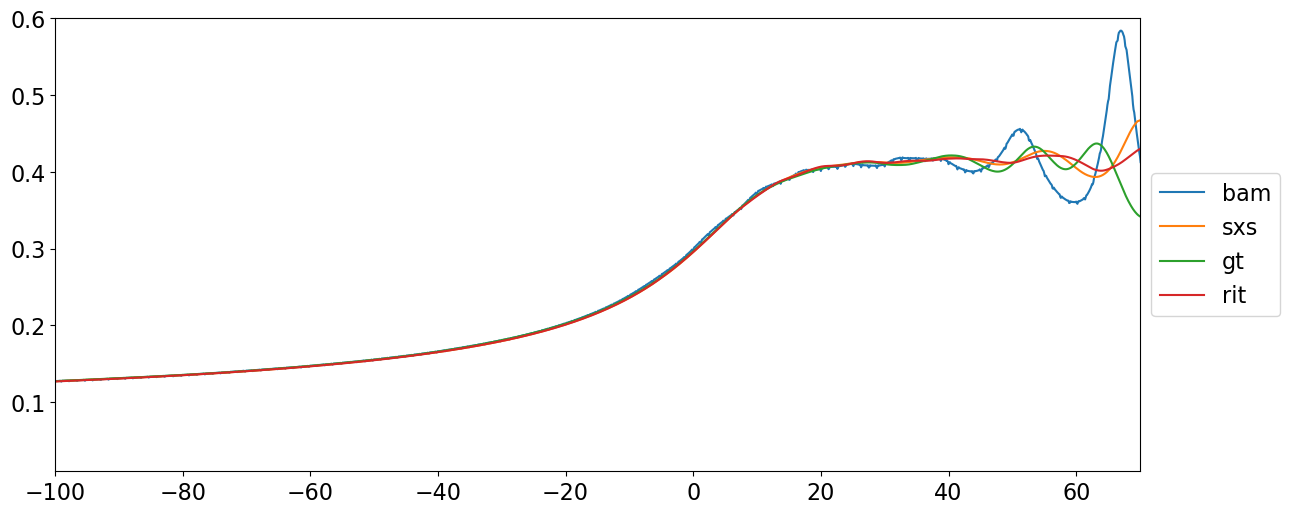

In [768]:
plt.figure(figsize=(14, 6), dpi=100)
for k in nrls.keys():
    t = nrls[k].times
    s = nrls[k].strain
    peak_idx = np.argmax(np.abs(s))
    t_max = t[peak_idx]

    amp = np.abs(s)
    phi = np.unwrap(np.angle(s))

    freq = IUS(t, phi).derivative()(t)

    plt.plot(t-t_max, freq, label=k)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlim(-100, 70)
plt.ylim(1e-2, 0.6)
# plt.yscale('log')

In [769]:
for k in nrls.keys():
    print(k, nrls[k].q, nrls[k].Mtotal)

bam 9.996319345018684 1.0038331
sxs 9.99996452092679 1.0000013347542
gt 9.996347593587576 1.00383194
rit 10.000171129300885 0.9999985216643223
